# TDA Testing: Graph Structure Differences Between Correlated & Uncorrelated Equity Prices

### Overview and Motivation
We know that equities who share numerous similar characteristics like sector and company products/services move closely in regards to stock performance. One of the more common ways to get a formal sense this comovement might be to measure the correlation between the prices on some period $[t_i, t_{i+l}]$. Similarly, we can visualize state patterns between the two series of prices by building a scatter plot where each point $p_i$ represents the price of two or more equities at time $t_i$:

$$
p_i = (P_{E_1}(t_i), P_{E_2}(t_i))
$$

A scatter plot like this allows us to guess the correlation pretty accurately, and gives us an immediate (but rough) idea of whether or not the prices of the equities do in fact move together.

In this notebook, we will use Topological Data Analysis (TDA) to uncover some structure similarities between Mapper graphs generated by highly correlated series of price data. Likewise, we will generate graphs for uncorrelated series of price data to observe graph structures of this case. Ultimately, we should be able to build an intuition to differentiate whether or not our data was highly correlated to begin with given resulting graphs.

### Mapper Algorithm
The Mapper algorithm uses a filteration process to project our data $X \subset \mathbb{R}^d$ onto a smaller dimension $\mathbb{R^k}, k < d$. In $\mathbb{R}^k$, we create overlapping covers to split and group the image points in the filtered space into these covers. After reclassifying our original pre-image points in $\mathbb{R}^d$ with their respective cover, we apply a clustering method onto each cover of points. This clustering step allows us to then construct a graph where each node represents a cluster, and each edge is present if and only if there exists overlapping points between clusters.

In this notebook, we will use the following methodology:

1. Normalize Data $X \subset \mathbb{R}^2$.
2. Choose lens (filtration) function $f: X \to \mathbb{R}$ and apply to our data.
3. Create overlapping intervals (covers) $I_1, I_2, ..., I_N$ such that:

$$
[\min f(X), \max f(X)] = \bigcup_{i=1}^N I_i.
$$

4. Classify points $f(X)$ by cover.
5. Cluster each group of points $f^{-1}(X) \in \mathbb{R}^d$ where $f(X)$ belongs to the group.
6. Construct graph where each node $N_i$ represents the cluster $C_i$, and an edge connects $N_i, N_j$ if and only if there exists a point $x \in X$ such that $x \in C_i \cap C_j$.

### Fetching Correlated Data Sets
In this section, we will look to construct and normalize price-price datasets $X_1, X_2, ..., X_5$ where the correlation between between its two involved series of price data is highly correlated. As a cutoff bias, we aim to achieve a correlation coefficient of $\rho > 0.85$.

To start, let us look within the Energy sector of the U.S. market and pull a handful of the largest equities within this sector. Then, using a time period of one year, we will check and rank the correlation between these stocks' performance.

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np

# Sector-leading equities:
eqs = ["XOM", "CVX", "COP", "WMB", "EPD", "KMI", "EOG", "MPC", "MPLX", "VLO", "PSX", "SLB", "BKR"]
price_series = []
for e in eqs:
    data = yf.Ticker(e).history(start="2024-01-01", end="2025-11-22", interval='1d')["Close"]
    price_series.append(data.rename(e))

price_df = pd.concat(price_series, axis=1)
corr_matrix = price_df.corr()
#print(corr_matrix)

threshold = 0.85

# upper-triangle mask (excluding diagonal)
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# apply mask + threshold
rows, cols = np.where((corr_matrix.values > threshold) & mask)

for i, j in zip(rows, cols):
    print(f"({corr_matrix.index[i]}, {corr_matrix.columns[j]}): {corr_matrix.iat[i, j]:.3f}")

(COP, SLB): 0.894
(WMB, EPD): 0.937
(WMB, KMI): 0.986
(WMB, MPLX): 0.960
(WMB, BKR): 0.876
(EPD, KMI): 0.944
(EPD, MPLX): 0.975
(EPD, BKR): 0.903
(KMI, MPLX): 0.951
(KMI, BKR): 0.867
(MPC, VLO): 0.942
(MPLX, BKR): 0.877


Above, we can select the following equity pairs to build our datasets with:

* $X_1 = [\text{WMB } \text{KMI}]$
* $X_2 = [\text{EPD } \text{MPLX}]$
* $X_3 = [\text{WMB } \text{MPLX}]$
* $X_4 = [\text{KMI } \text{MPLX}]$
* $X_2 = [\text{MPC } \text{VLO}]$

And out of curiosity, we can generate a scatter plot for $X_1$:

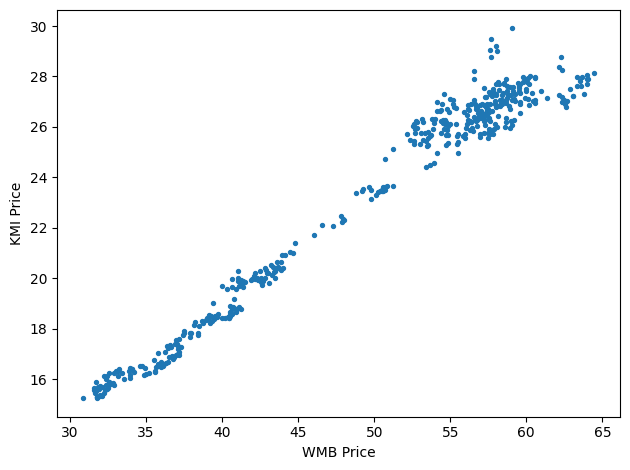

In [13]:
import matplotlib.pyplot as plt

plt.scatter(x=price_df['WMB'], y=price_df['KMI'], s=8)
plt.xlabel("WMB Price")
plt.ylabel("KMI Price")
plt.tight_layout()
plt.show()

Now that we know what data we are going to work with going forward in this section, we will build $X_1, .., X_5 \subset \mathbb{R}^2$ and normalize values using a Z-score. For a value $x$ in some data:

$$
x_{normalized} = \frac{x - \mu}{\sigma}
$$

In [22]:
from sklearn.preprocessing import StandardScaler

# Build X_1 with raw prices
X1_raw = np.column_stack([price_df["WMB"], price_df["KMI"]])
print("X1_raw.head:\n", X1_raw[:5])

# Normalize X_1 raw
X1 = StandardScaler().fit_transform(X1_raw)
print("X1.head:\n", X1[:5])

# Repeat for other datasets
X2 = StandardScaler().fit_transform(np.column_stack([price_df["EPD"], price_df["MPLX"]]))
X3 = StandardScaler().fit_transform(np.column_stack([price_df["WMB"], price_df["MPLX"]]))
X4 = StandardScaler().fit_transform(np.column_stack([price_df["KMI"], price_df["MPLX"]]))
X5 = StandardScaler().fit_transform(np.column_stack([price_df["MPC"], price_df["VLO"]]))


X1_raw.head:
 [[33.13132858 16.1315918 ]
 [33.86819839 16.33063507]
 [33.41114807 16.2401619 ]
 [33.15930939 16.30349159]
 [33.25258636 16.38492203]]
X1.head:
 [[-1.62577139 -1.56131053]
 [-1.55151396 -1.51625307]
 [-1.59757282 -1.5367335 ]
 [-1.62295165 -1.52239755]
 [-1.61355174 -1.50396413]]


### Filtration Functions
We can choose from a large selection of possible filtration functions to use in this experiment. The choices are extremely vast, but to stay on the topic of correlation, we might want to start with a function $f$ that measures the distance between $x, y$ for $(x,y) \in \mathbb{R}^2$. So, we will use the following function for the experiment:

$$
f: X \subset \mathbb{R}^2 \to \mathbb{R}, \text{ } f(x, y) =  |x - y|.
$$

In [26]:
def f(X: np.ndarray) -> np.ndarray:
    X = np.asarray(X, dtype=np.float64)
    return np.abs(X[..., 0] - X[..., 1])

# example output of f(X1)
print("First few differences of X1:")
print(f(X1)[:5])

First few differences of X1:
[0.06446087 0.03526088 0.06083932 0.10055411 0.10958761]


Alternatively, we could have chosen functions like softmax, 2-norm, max, min, etc., but we will stick with the distance function for the graph generation in this notebook.

### Graph Building
Using libraries like **kmapper** and **sklearn**, we can ease the graph generation process and construct interactive graphs in HTML format. Let us start with our first data set, $X_1$, which we already normalized. First, we can initialize our Mapper object from the **kmapper** library and apply our lens (filter) function to our data:

In [28]:
import kmapper as km

# Initialize KeplerMapper and compute filtration function
mapper = km.KeplerMapper(verbose=1)
lens = f(X1)

KeplerMapper(verbose=1)


And now we can define our parameters for our covers, which are closed intervals when we consider $\mathbb{R}^1$. With $N$ covers and and overlap percentage $\alpha$, we construct our covers of $f(X_1)$:

*Recall we wish to construct intervals $I_i$ such that all of $ \text{Im}f$ is covered, i.e.:* $[\min f(X), \max f(X)] = \bigcup_i I_i.$


We define the width of each interval $I_i$:

$$
w = \frac{\max f(X) - \min f(X)}{N- \alpha (N-1)},
$$

and our step magnitude as $s = w(1-\alpha)$. Iteratively, we build covers $I_1, I_2, ..., I_N$:

$$
I_j = [\min f(X) + (j-1)s, (\min f(X) + (j-1)s)+w]
$$

The following code will both set our cover parameters and **DBSCAN** clustering parameters.

In [29]:
from sklearn.cluster import DBSCAN

# Build 6 intervals with 30% overlap
cover = km.Cover(n_cubes=6, perc_overlap=0.3)

# Set DBSCAN clustering params for kmapper
clusterer = DBSCAN(eps=0.5, min_samples=3)

In **learning.ipynb**, you can see visuals of all steps up to the graph. In this notebook, we focus more on the resulting graphs rather than intermediate processes. Let us construct the final graph for data $X_1$:

In [31]:
# Build graph
graph = mapper.map(
    lens,
    X1,
    cover=cover,
    clusterer=clusterer
)

color_values = lens
mapper.visualize(graph, path_html="WMB_KMI_price_map.html", title="Mapper Graph: WMB-KMI Price (distance filter)", color_values=color_values, color_function_name="Absolute Difference")

Mapping on data shaped (476, 2) using lens shaped (476,)

Creating 6 hypercubes.

Created 7 edges and 8 nodes in 0:00:00.015002.
Wrote visualization to: WMB_KMI_price_map.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper Graph: WMB-KMI Price (distance filter) | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n